In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from raytracing import *
from tdwg.lib.simulation import *
import tdwg.lib.pnn_utils as pnn_utils 
from tdwg.lib.pnn_utils import binarize, EMD, L1, L2, biasing, neighbor_biasing
from tdwg.lib.create_noise import make_boxed_noise
from tdwg.lib.DMD_patterns import generate_all_on
from tdwg.lib.pat import make_pat_func
from tdwg.lib.misc_helpers import Timer
import copy

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.nn import L1Loss

In [3]:
from IPython.core.debugger import set_trace

In [178]:
numpy_seed = 0
torch_seed = 0

# inverse design training parameters
biasing_parameter = 0.0 # biasing parameter k from Eq. (4) in https://arxiv.org/pdf/1709.08809.pdf
iterations = 100 # number of gradient descent steps on index profile 
device = 'cuda:0' # device on which training is performed
n_training_samples = 64 # number of training samples
lr = 6e-5 # initial learning rate
gamma = 0.995 # learning rate scheduler exponent
lag_amp = 5 # determines how strictly the parameter limits are obeyed
soft_relu_factor = 20 # beta parameter from https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html

# chip parameters (lengths in MICROMETERS)
Lz = 20e3 # length of waveguide
Ly = 1.8e3 # width of simulated waveguide area
carrier_diffusion_length = 5 # carrier diffusion length
n_wg = 1.942 # effective index of waveguide 
delta_n_val= 2e-3 # n_wg - 1.444 # (effective) index modulation in bright regions
L_padding = 2.5e3 # length of single-mode input and output waveguides
sm_wg_width = 50 # single mode waveguide width

# input and output parameters
w0 = 17 # beam waist (um)
mode_spacing = 150 # distance between modes coupling into the waveguide (um)
n = 3 # number of input and output modes (=dimension of unitary)

# simulation parameters
Ny = 2**11 
dz = 1.55 / delta_n_val / 20
N_com = 1 # after how many integration steps to sample the E-field

In [179]:
torch.manual_seed(torch_seed)
torch.set_num_threads(4) # to limit CPU usage

In [180]:
class TDwgNet(nn.Module):
    def __init__(self, nin, nout, dz, device = 'cpu'):
        super(TDwgNet, self).__init__()
        # create waveguide simulation object
        self.wg = WaveguideSimulation(Ly=Ly, Ny=Ny, Lz=Lz, dz=dz, delta_n_val=delta_n_val, device=device)
        self.wg.N_com = N_com
        
        # initialize index profile with amplitude delta_n_val/2
        self.delta_n = pnn_utils.Parameter(delta_n_val/2 * torch.ones([self.wg.Nz, self.wg.Ny], device = device, requires_grad = True, dtype = torch.float32), limits = [0, delta_n_val]) 
        self.wg.delta_n = 1 * self.delta_n

        rayleigh_range = beam_waist_to_rayleigh_range(w0)
        # set physical range of inputs and output modes (um)
        yrange_in = mode_spacing * (nin - 1)
        yrange_out = mode_spacing * (nout - 1)
        # set their input positions
        ypos_in = np.linspace(-yrange_in/2, yrange_in/2, nin)
        ypos_out = np.linspace(-yrange_out/2, yrange_out/2, nout)
        # find positions in units of pixels
        ypos_in_inds = np.array([self.wg.y2ind(y) for y in ypos_in])
        ypos_out_inds = np.array([self.wg.y2ind(y) for y in ypos_out])
        # set up input and output mode envelopes
        input_modes, output_modes = [], []
        for ypos in ypos_in:
            i = torch.from_numpy(gaussian_beam_from_q_parameter(self.wg, 1j*rayleigh_range, center_um = ypos))
            i /= torch.norm(i)
            input_modes.append(i)
        for ypos in ypos_out:
            o = torch.from_numpy(gaussian_beam_from_q_parameter(self.wg, 1j*rayleigh_range, center_um = ypos))
            o /= torch.norm(o)
            output_modes.append(o)
        self.input_modes = torch.vstack(input_modes).to(self.wg.device)
        self.output_modes = torch.vstack(output_modes).to(self.wg.device)
        
        # find waveguide width in pixels
        sm_wg_width_inds = self.wg.y2ind(sm_wg_width) - self.wg.y2ind(0)
        # write single mode waveguides into padding
        self.n_padding_z =  torch.zeros([int(L_padding / dz), Ny], device = device)
        for ypos in ypos_in_inds:
            self.n_padding_z[:, ypos - int(sm_wg_width_inds/2):ypos + int(sm_wg_width_inds/2) + 1] = delta_n_val
        
    def pad_delta_n(self, delta_n):
        # pads slab index profile with single mode waveguides on either side
        delta_n = torch.vstack((self.n_padding_z, delta_n, self.n_padding_z))
        return delta_n
        
    def forward(self, delta_n):
        # set electric field entering simulation region from the left
        input_beam = self.x@self.input_modes
        self.wg.set_input_beam(input_beam)
        
        # set binarized refractive index profile
        self.wg.delta_n = 1 * self.pad_delta_n(delta_n)
        self.wg.delta_n = binarize(self.wg.delta_n, *self.delta_n.limits)
        
        # run simulations
        A_z = self.wg.run_simulation()
        return A_z
    
    def forward_continuous(self, delta_n):
        # set electric field entering simulation region from the left
        input_beam = self.x@self.input_modes
        self.wg.set_input_beam(input_beam)

        # set continuous refractive index profile
        delta_n = self.wg.smoothen_spatial_map(delta_n, carrier_diffusion_length)
        self.wg.delta_n = 1 * self.pad_delta_n(delta_n)

        # run simulations
        A_z = self.wg.run_simulation()
        return A_z

In [181]:
nin, nout = n, n
tdwg_pnn = TDwgNet(nin, nout, dz = dz, device = device)

# create random unitary
H = 10*np.pi*(torch.rand(nin, nout, dtype = torch.complex128) + 1j*torch.rand(nin,nout))
H = H + H.T.conj()
U = torch.matrix_exp(1j*H).to(tdwg_pnn.wg.device)

# set forward and backward pass function (use a continuous profile on both for now)
tdwg_pnn_pat = make_pat_func(
    f_forward = tdwg_pnn.forward_continuous, 
    f_backward = tdwg_pnn.forward_continuous)

loss_list = []

# create optimizer and scheduler
optimizer = optim.Adam(tdwg_pnn.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

# create random initial index profile with given correlation length
# tdwg_pnn.delta_n.data = tdwg_pnn.wg.delta_n_val/2*torch.ones([tdwg_pnn.wg.Nz, tdwg_pnn.wg.Ny], dtype = torch.float64)

# training loop
tdwg_pnn.train()
for i in range(iterations):
    optimizer.zero_grad()

    # create training data:
    # create random inputs
    x = torch.rand([n_training_samples,nin], device = tdwg_pnn.wg.device, dtype = torch.complex128)
    x = (x.T / torch.norm(x, dim = -1)).T
    # create associated outputs
    y = x@U
    tdwg_pnn.x = x

    # calculate field and intensity distributions associated with inputs/outputs
    input = x@tdwg_pnn.input_modes
    target = y@tdwg_pnn.output_modes
    input_I = torch.abs(input)**2
    target_I = torch.abs(target)**2

    # run forward pass and extract fields at output facet
    A_z = tdwg_pnn_pat(tdwg_pnn.delta_n)
    output = A_z[-1]
    output_I = torch.abs(output)**2

    # compute loss and backpropagate
    l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp = lag_amp, factor = soft_relu_factor)
    l_objective = L2(output, target)
    l = l_objective + l_lagrange
    l.backward()
    optimizer.step()
    scheduler.step()
    loss_list.append(l.detach().cpu().data)

    # print status
    if i%10 == 0:
        print(f'Iteration {i}, loss = {l:.2f}')
        print(f'Objective loss: {l_objective:.4f}, Lagrange loss {l_lagrange:.4f}, Max value: {tdwg_pnn.delta_n.max():.2e}, Min value: {tdwg_pnn.delta_n.min():.2e}')

Iteration 0, loss = 1.04
Objective loss: 1.0439, Lagrange loss 0.0000, Max value: 1.06e-03, Min value: 9.40e-04
Iteration 10, loss = 0.34
Objective loss: 0.3392, Lagrange loss 0.0002, Max value: 1.65e-03, Min value: 3.53e-04
Iteration 20, loss = 0.17
Objective loss: 0.1656, Lagrange loss 0.0009, Max value: 2.07e-03, Min value: -6.89e-05
Iteration 30, loss = 0.13
Objective loss: 0.1253, Lagrange loss 0.0013, Max value: 2.21e-03, Min value: -1.92e-04
Iteration 40, loss = 0.10
Objective loss: 0.0963, Lagrange loss 0.0010, Max value: 2.33e-03, Min value: -1.15e-04
Iteration 50, loss = 0.07
Objective loss: 0.0643, Lagrange loss 0.0008, Max value: 2.34e-03, Min value: -1.59e-04
Iteration 60, loss = 0.04
Objective loss: 0.0424, Lagrange loss 0.0008, Max value: 2.34e-03, Min value: -2.95e-04
Iteration 70, loss = 0.02
Objective loss: 0.0225, Lagrange loss 0.0008, Max value: 2.32e-03, Min value: -3.23e-04
Iteration 80, loss = 0.01
Objective loss: 0.0128, Lagrange loss 0.0008, Max value: 2.29e-03

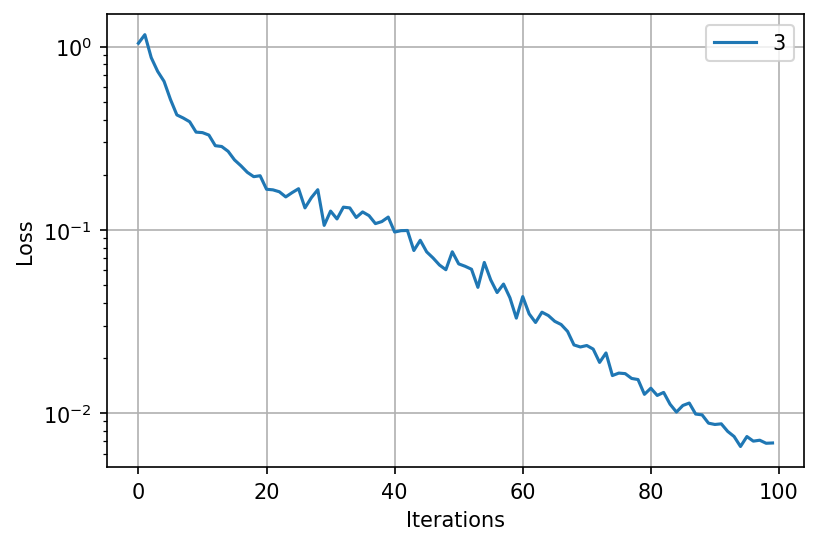

In [182]:
plt.figure(dpi = 150)
plt.plot(loss_list, label = n)
plt.legend()
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.grid()

Text(0, 0.5, 'x (um)')

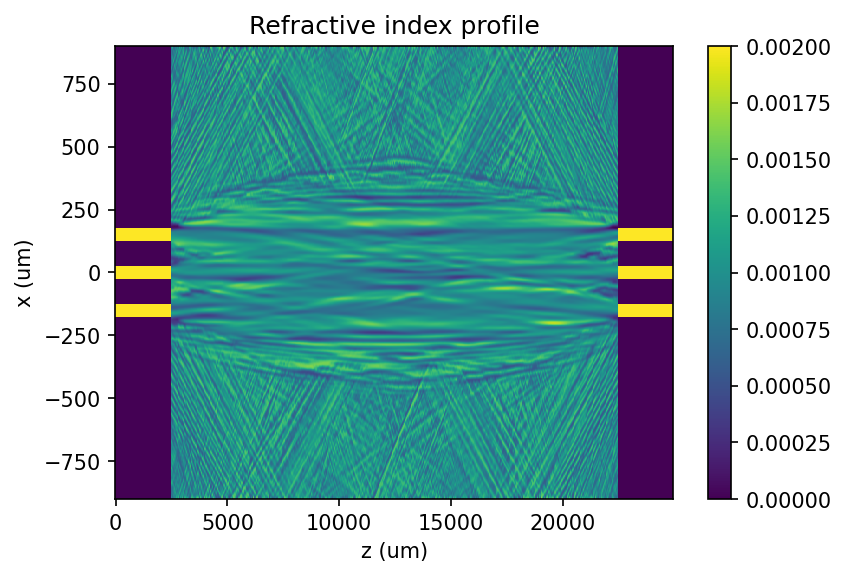

In [183]:
# visualize trained index profile
plt.figure(dpi = 150)
plt.title('Refractive index profile')
plt.pcolormesh(tdwg_pnn.wg.z_list, tdwg_pnn.wg.y_axis, tdwg_pnn.wg.delta_n.cpu().detach().T)
plt.colorbar()
plt.xlabel('z (um)')
plt.ylabel('x (um)')

## Check results on training dataset

In [184]:
# set inputs and target to training dataset
tdwg_pnn.x = x
input = x@tdwg_pnn.input_modes
target = y@tdwg_pnn.output_modes
input_I = torch.abs(input)**2
target_I = torch.abs(target)**2

# run simulations with continuous and binary delta n
with Timer():
    with torch.no_grad():
        for i in range(10):
            A_z = tdwg_pnn.forward_continuous(tdwg_pnn.delta_n)

Elapsed: 0.7043471336364746


In [185]:
inp_A = A_z[0]
out_A = A_z[-1]
# out_A_binary = A_z_binary[-1]

inp_I = torch.abs(inp_A)**2
out_I = torch.abs(out_A)**2
# out_I_binary = torch.abs(out_A_binary)**2

In [186]:
ind = 0

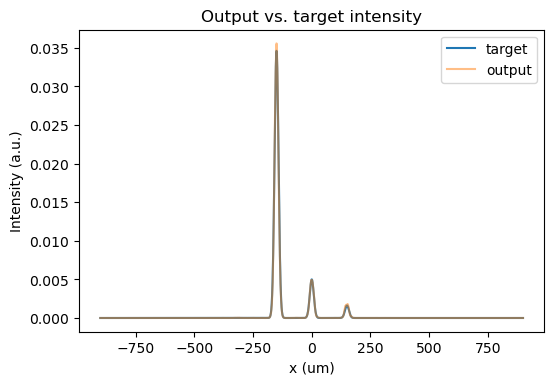

In [187]:
plt.figure(dpi=100)
plt.plot(tdwg_pnn.wg.y_axis, target_I[ind].cpu().detach().numpy(), label="target")
plt.plot(tdwg_pnn.wg.y_axis, out_I[ind].cpu().detach().numpy(), label="output", alpha = 0.5)
# plt.plot(tdwg_pnn.wg.y_axis, out_I_binary[ind].cpu().detach().numpy(), label="output binary", alpha = 0.5)

plt.title('Output vs. target intensity')
plt.xlabel("x (um)")
plt.ylabel("Intensity (a.u.)")
plt.legend()

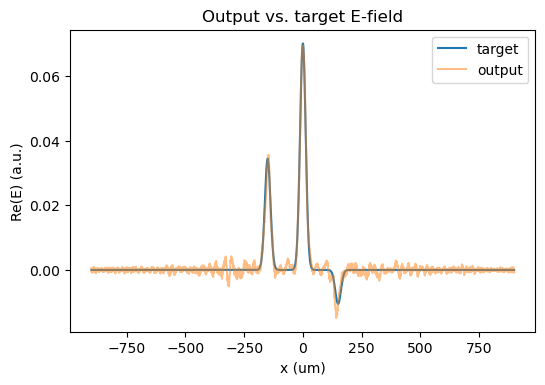

In [188]:
plt.figure(dpi=100)
plt.plot(tdwg_pnn.wg.y_axis, target[ind].real.cpu().detach().numpy(), label="target")
plt.plot(tdwg_pnn.wg.y_axis, out_A[ind].real.cpu().detach().numpy(), label="output", alpha = 0.5)
# plt.plot(tdwg_pnn.wg.y_axis, out_A_binary[ind].real.cpu().detach().numpy(), label="output binary", alpha = 0.5)

plt.title('Output vs. target E-field')
plt.xlabel("x (um)")
plt.ylabel("Re(E) (a.u.)")
plt.legend()

## Test dataset

In [189]:
n_test_samples = 1

In [190]:
# create random inputs
# x_test = torch.rand([n_test_samples,nin], device = tdwg_pnn.wg.device, dtype = torch.complex128)
# x_test = torch.zeros([n_test_samples,nin], device = tdwg_pnn.wg.device, dtype = torch.complex128)
# x_test[0,int(n/4)] = 1

# create "base vector inputs"
x_test = torch.eye(n, device = tdwg_pnn.wg.device, dtype = torch.complex128)
x_test = (x_test.T / torch.norm(x_test, dim = -1)).T
# create associated outputs
y_test = x_test@U
tdwg_pnn.x = x_test

# calculate field and intensity distributions associated with inputs/outputs
input_test = x_test@tdwg_pnn.input_modes
target_test = y_test@tdwg_pnn.output_modes
input_I_test = torch.abs(input_test)**2
target_I_test = torch.abs(target_test)**2

In [191]:
# run simulations with continuous delta n
A_z_test = tdwg_pnn.forward_continuous(tdwg_pnn.delta_n)

In [192]:
inp_A_test = A_z_test[0]
out_A_test = A_z_test[-1]

inp_I_test = torch.abs(inp_A_test)**2
out_I_test = torch.abs(out_A_test)**2

### Compare output to target intensity

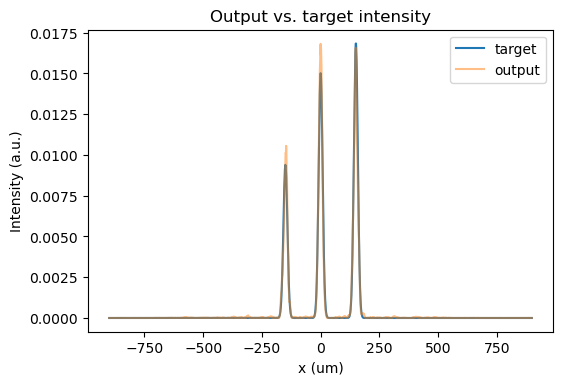

In [193]:
plt.figure(dpi=100)
plt.plot(tdwg_pnn.wg.y_axis, target_I_test[ind].cpu().detach().numpy(), label="target")
plt.plot(tdwg_pnn.wg.y_axis, out_I_test[ind].cpu().detach().numpy(), label="output", alpha = 0.5)
# plt.plot(tdwg_pnn.wg.y_axis, out_I_test_binary[ind].cpu().detach().numpy(), label="output binary", alpha = 0.5)

plt.title('Output vs. target intensity')
plt.xlabel("x (um)")
plt.ylabel("Intensity (a.u.)")
plt.legend()

### Compare real output to target field

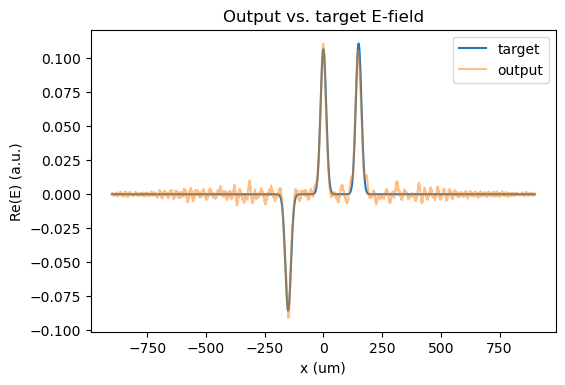

In [194]:
plt.figure(dpi=100)
plt.plot(tdwg_pnn.wg.y_axis, target_test[ind].real.cpu().detach().numpy(), label="target")
plt.plot(tdwg_pnn.wg.y_axis, out_A_test[ind].real.cpu().detach().numpy(), label="output", alpha = 0.5)

plt.title('Output vs. target E-field')
plt.xlabel("x (um)")
plt.ylabel("Re(E) (a.u.)")
plt.legend()

## 2D visualizations

(-300.0, 300.0)

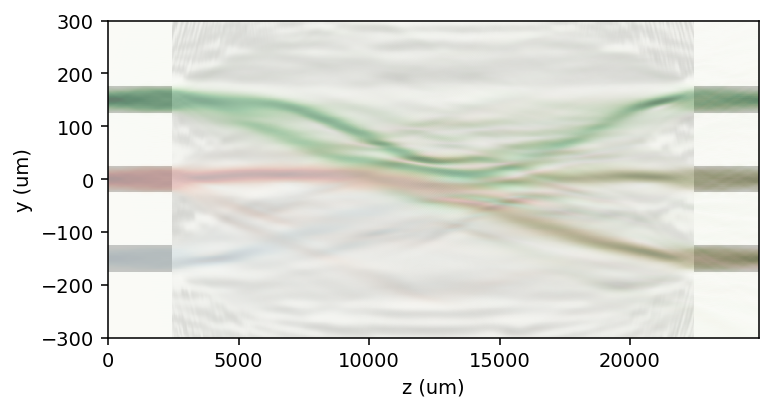

In [195]:
plt.figure(dpi=140, figsize = [6,  3])

plt.pcolormesh(tdwg_pnn.wg.z_list, tdwg_pnn.wg.y_axis, torch.abs((A_z_test[:,0]).detach().cpu()).T, cmap="Blues", alpha = 0.5)
plt.pcolormesh(tdwg_pnn.wg.z_list, tdwg_pnn.wg.y_axis, torch.abs((A_z_test[:,1]).detach().cpu()).T, cmap="Reds", alpha = 0.5)
plt.pcolormesh(tdwg_pnn.wg.z_list, tdwg_pnn.wg.y_axis, torch.abs((A_z_test[:,2]).detach().cpu()).T, cmap="Greens", alpha = 0.5)
plt.pcolormesh(tdwg_pnn.wg.z_list, tdwg_pnn.wg.y_axis, tdwg_pnn.wg.delta_n.detach().cpu().T, cmap="Greys", alpha = 0.2)
plt.xlabel("z (um)")
plt.ylabel("y (um)")
plt.ylabel("y (um)")
plt.ylim(-300, 300)